In [1]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed
mean_gray = 0.1307
stddev_gray = 0.3081

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn)
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms_ori = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))])

transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])

#Load our dataset
train_dataset = datasets.MNIST(root = './data',
                            train = True,
                            transform = transforms_ori,
                            download = True)

test_dataset = datasets.MNIST(root = './data',
                            train = False,
                            transform = transforms_ori)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.68MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



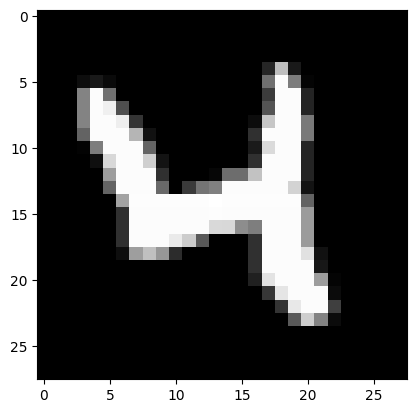

In [3]:
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [5]:
print(train_dataset[20][1])   #Print the corresponding label for the image

4


In [6]:
batch_size = 100
epochs = 10

In [7]:
#Make the dataset iterable
train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)

In [8]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [9]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before!
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568)
        #Then we forward through our fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [10]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [11]:
#Understand what's happening
iteration = 0
correct_nodata = 0
correct_data = 0
for i,(inputs,labels) in enumerate (train_load):
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted_nodata = torch.max(output, 1)
    print("Predicted Shape",predicted_nodata.shape)
    print("Predicted Tensor:")
    print(predicted_nodata)
    correct_nodata += (predicted_nodata == labels).sum()
    print("Correct Predictions: ",correct_nodata)
    _, predicted_data = torch.max(output.data, 1)
    correct_data += (predicted_data == labels.data).sum()
    print("Correct Predictions:",correct_data)


    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([8, 4, 9, 8, 2, 2, 2, 9, 1, 1, 9, 9, 2, 2, 4, 8, 8, 1, 2, 4, 5, 8, 2, 1,
        2, 8, 8, 4, 9, 1, 5, 2, 9, 9, 9, 2, 9, 1, 1, 2, 2, 2, 2, 2, 8, 1, 1, 2,
        2, 2, 1, 2, 0, 2, 8, 8, 9, 8, 8, 2, 8, 8, 4, 6, 8, 1, 2, 1, 2, 9, 9, 2,
        8, 2, 2, 2, 8, 4, 2, 9, 9, 8, 9, 8, 1, 2, 9, 0, 9, 2, 2, 8, 1, 2, 9, 2,
        8, 1, 1, 2])
Correct Predictions:  tensor(13)
Correct Predictions: tensor(13)


In [15]:
#Training the CNN
num_epochs = 5

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs):
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()                   # Put the network into training mode

    for i, (inputs, labels) in enumerate(train_load):

        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)

        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()       # Accumulate the loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update the weights

        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))

    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode

    for i, (inputs, labels) in enumerate(test_load):

        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)

        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels) # Calculate the loss
        loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

        iterations += 1

    # Record the Testing loss
    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))

    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1],
             test_loss[-1], test_accuracy[-1]))

Epoch 1/5, Training Loss: 0.114, Training Accuracy: 96.757, Testing Loss: 0.002, Testing Acc: 97.710
Epoch 2/5, Training Loss: 0.092, Training Accuracy: 97.353, Testing Loss: 0.001, Testing Acc: 98.050
Epoch 3/5, Training Loss: 0.080, Training Accuracy: 97.680, Testing Loss: 0.001, Testing Acc: 98.340
Epoch 4/5, Training Loss: 0.070, Training Accuracy: 97.983, Testing Loss: 0.001, Testing Acc: 98.450
Epoch 5/5, Training Loss: 0.063, Training Accuracy: 98.120, Testing Loss: 0.001, Testing Acc: 98.530


In [16]:
#Run this if you want to save the model
torch.save(model.state_dict(),'CNN_MNIST.pth')

In [25]:
test_loss

[tensor(0.0023, grad_fn=<DivBackward0>),
 tensor(0.0013, grad_fn=<DivBackward0>),
 tensor(0.0012, grad_fn=<DivBackward0>),
 tensor(0.0011, grad_fn=<DivBackward0>),
 tensor(0.0007, grad_fn=<DivBackward0>)]

In [24]:
test_accuracy

[tensor(97.7100),
 tensor(98.0500),
 tensor(98.3400),
 tensor(98.4500),
 tensor(98.5300)]

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

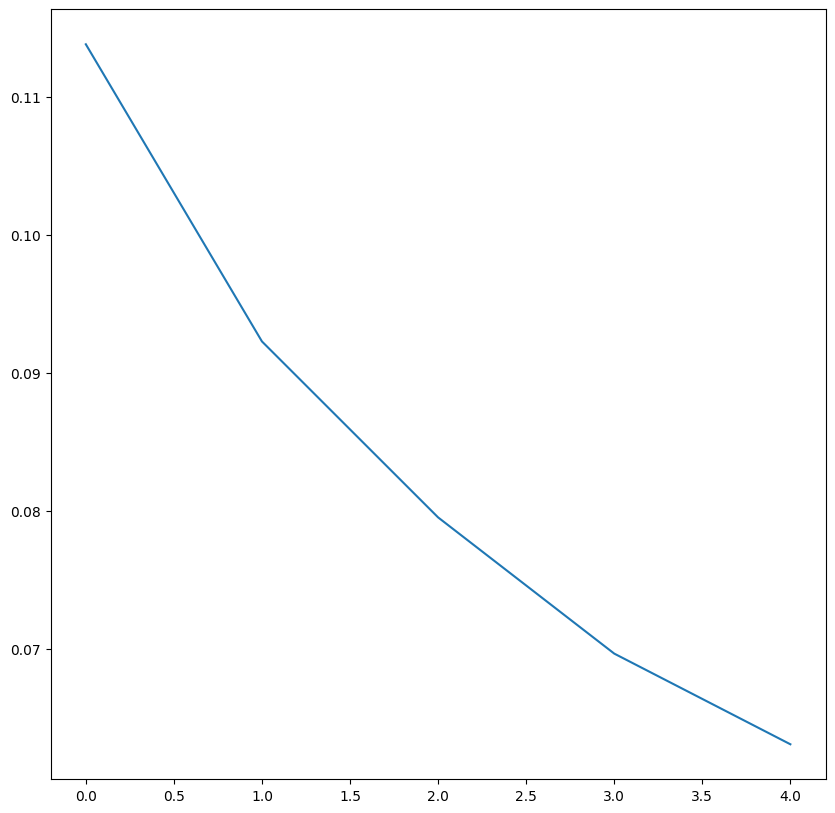

In [17]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

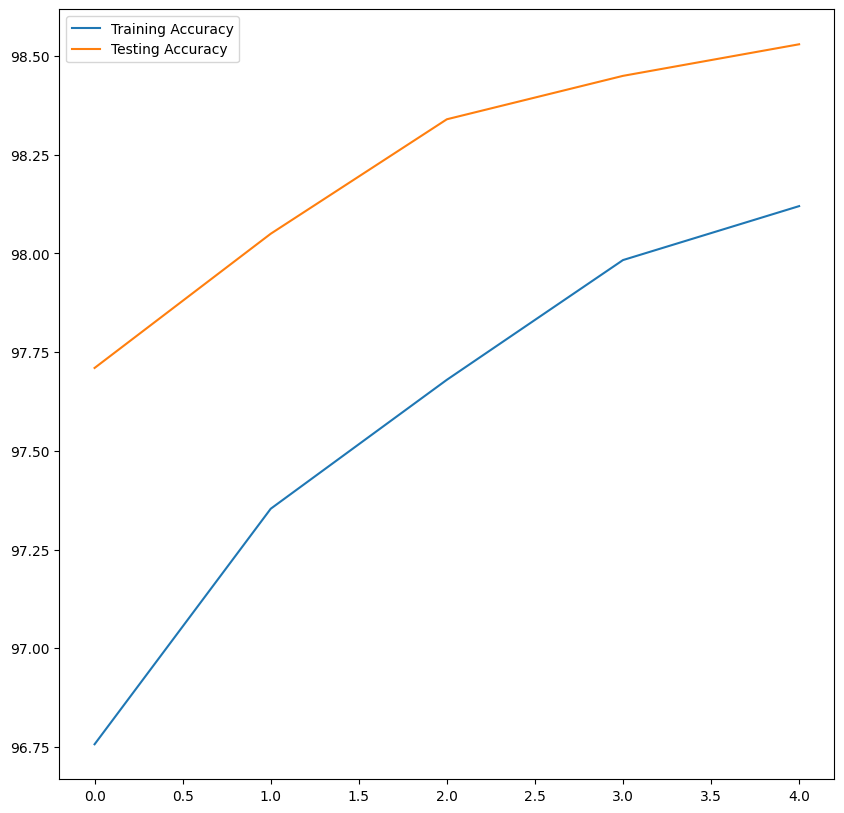

In [26]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [27]:
#Run this if you want to load the model
model.load_state_dict(torch.load('CNN_MNIST.pth'))

<ipython-input-27-0c95fb8960a2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CNN_MNIST.pth'))


<All keys matched successfully>

In [34]:
from google.colab.patches import cv2_imshow
#Predict your own image
def predict(img_name,model):
    image = cv2.imread(img_name,0)   #Read the image
    ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)   #Threshold the image
    img = 255-thresholded           #Apply image negative
    # cv2.imshow('Original',img)      #Display the processed image
    cv2_imshow(img) # change to this one due to cv2.imshow cannot work well in google clob
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img = Image.fromarray(img)      #Convert the image to an array
    img = transforms_photo(img)     #Apply the transformations
    img = img.view(1,1,28,28)       #Add batch size
    img = Variable(img)             #Wrap the tensor to a variable

    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return  predicted.item()

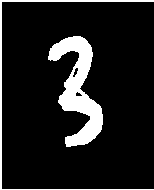

tensor([[-4.8319,  0.5291,  1.8886,  8.9719, -2.6615,  0.1314, -3.4621,  0.1941,
         -0.2392,  1.9228]], grad_fn=<AddmmBackward0>)
tensor([[-4.8319,  0.5291,  1.8886,  8.9719, -2.6615,  0.1314, -3.4621,  0.1941,
         -0.2392,  1.9228]])
The Predicted Label is 3


In [35]:
pred = predict('3.jpg', model)
print("The Predicted Label is {}".format(pred))